In [85]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [86]:
import os
import kagglehub
import pandas as pd
import numpy as np

#downloading dataset

path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")


fake_csv_path = os.path.join(path, "Fake.csv")
true_csv_path = os.path.join(path, "True.csv")


fake = pd.read_csv(fake_csv_path)
true = pd.read_csv(true_csv_path)

In [87]:
fake['label'] = 0
true['label'] = 1
#labelling for future use
dataset = pd.concat([fake, true], ignore_index=True)

In [88]:
dataset.drop(['title', 'subject', 'date'], axis = 1, inplace=True)
#Dropping unuseful data from dataframe

In [89]:
dataset.isnull().sum()
dataset.duplicated().sum()
dataset.drop_duplicates(inplace=True)

#removing duplicates and checking for null values

In [90]:
    popular_emoticons = {
    # Positive
    ":)": "happy",
    ":-)": "happy",
    ":D": "laughing",
    ":-D": "laughing",
    ";)": "winking",
    ";-)": "winking",
    ":')": "tears_of_joy",
    "<3": "love",

    # Negative
    ":(": "sad",
    ":-(": "sad",
    ":'(": "crying",
    ">:(": "angry",
    "D:": "shocked",

    # Other
    ":P": "playful",
    ":p": "playful",
    ":O": "surprised",
    ":o": "surprised",
    ":|": "neutral",
    ":/": "skeptical",
    ":\\": "skeptical",
    ":'-)": "tears_of_joy",

    # Popular text-based
    "^^": "happy",
    "^_^": "happy",
    "T_T": "crying",
    "-_-": "annoyed"
}

In [91]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]

#function to remove stop words

In [92]:
import re

def clean_text_advanced(text):
    # Step 1: Remove @-mentions
    text = re.sub(r'@\w+', '', text)

    # Step 2: Remove mixed alphanumeric words (e.g., abc123, x1y2z3)
    text = re.sub(r'\b\w*[0-9]+\w*\b', '', text)

    # Step 3: Split internal punctuation (., -, _) into separate tokens
    text = re.sub(r'([.-_])', r' \1 ', text)

    # Step 4: Separate external punctuation (!?.,)
    text = re.sub(r'([!?.,])', r' \1 ', text)

    # Step 5: Clean extra spaces
    text = ' '.join(text.split())

    return text

def fix_contractions(text):
    # Separate contractions into two parts using regex
    text = re.sub(r"\b([A-Za-z]+)('ll|'re|'ve|'d|'m|'s|'t)\b", r"\1 \2", text)
    text = re.sub(r"\b([Cc]an)(not)\b", r"\1 \2", text)
    text = re.sub(r"\b([Ww]on)(\'t)\b", r"\1 \2", text)
    text = re.sub(r"\b([Ss]han)(\'t)\b", r"\1 \2", text)
    return text


def normalize_repeats(word):
    """
    Detects and replaces elongated characters (e.g. 'soooo' -> 'so <REPEAT:5>').
    Returns a list of tokens: base + <REPEAT:n>
    """
    match = re.search(r"(.)\1{2,}", word) # changes only when there is continuous repition of a single character more than two times
    if match:
        repeated_char = match.group(1)
        repeat_seq = match.group(0)
        repeat_len = len(repeat_seq)

        # Replace only the first repeated sequence
        normalized = re.sub(r"(.)\1{2,}", r"\1", word, count=1)
        return [normalized, f"<REPEAT:{repeat_len}>"]
    return word #returns a list of two string one is the corrected word and other is the repeated token

def tokenizer(text):

    text = text.lower()

    text = clean_text_advanced(text)

    text = fix_contractions(text)

    text = re.sub(r"[^a-zA-Z0-9\s']", '', text)

    #to remove websites
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r"\b[\w.-]+\.com\S*","", text)

    #to remove single characters
    text = re.sub(r"\b\w\b", "", text)

    words = text.split()

    tokens = []

    for token in words:
        if token in popular_emoticons:
            token = popular_emoticons[token]

        temp = normalize_repeats(token)
        if type(temp) == list:
          tokens.extend(temp)
        else:
          tokens.append(temp)





    return remove_stopwords(tokens)

#custom tokenizer

In [93]:
def pos_tagger(tokens):
  pos_tags = []

  verbs = [
    "ask", "be", "become", "begin", "call", "can", "come", "could", "do", "feel",
    "find", "get", "give", "go", "have", "hear", "help", "keep", "know", "leave",
    "let", "like", "live", "look", "make", "may", "mean", "might", "move", "need",
    "play", "put", "run", "say", "see", "seem", "should", "show", "start", "take",
    "talk", "tell", "think", "try", "turn", "use", "want", "will", "work", "would"
    ]

  adj = ['big', 'cold', 'good', 'small', 'hot', 'expensive', 'difficult', 'easy',
         'free', 'open', 'closed', 'sick', 'nice', 'hungry', 'late', 'right',
         'happy', 'new', 'old', 'tall', 'ready', 'far']

  for token in tokens:

    tag = 'N'

    if re.match(r"<REPEAT:\d+>", token):
      pos_tags.append((token, 'M'))
      continue

    if token.startswith("'"):
            tag = 'V' if token in {"'s", "'m", "'re", "'ve", "'d", "'ll"} else 'N'


    elif token in verbs:
      tag = 'V'
    elif token in adj:
      tag = 'A'

    elif re.match(r"\b\w+ing\b|\b\w+ed\b|\b\w+ate\b|\b\w+ize\b|\b\w+ify\b",token):
      tag = 'V'
    elif re.match(r"\b\w+able\b|\b\w+ic\b|\b\w+al\b|\b\w+ful\b|\b\w+less\b|\b\w+ous\b|\b\w+ish\b|\b\w+ive\b", token):
      tag = 'A'

    pos_tags.append((token, tag))


  return pos_tags

#pos tagger

In [94]:
def lemmatizer(pos_tags):


  #reference for lemmatizing https://www.grammar.cl/Notes/Plural_Nouns.htm
  processed = []
  irregular_nouns = {
        "children": "child",
        "mice": "mouse",
        "geese": "goose",
        "men": "man",
        "women": "woman",
        "teeth": "tooth",
        "feet": "foot",
        "people": "person"
    }

  for token, tag in pos_tags:

    word = token

    if tag == 'V':

            if word.endswith("ies"):
                word = word[:-3] + "y"
            elif word.endswith("ing") and len(word) > 4:
                word = word[:-3]
            elif word.endswith("ed") and len(word) > 3:
                word = word[:-2]
            elif word.endswith("es") and len(word) > 3:
                word = word[:-2]
            elif word.endswith("s") and len(word) > 3:
                word = word[:-1]

    elif tag == 'N':
            if word in irregular_nouns:
                word = irregular_nouns[word]
            elif re.match(r".+[^aeiou]ies$", word):  # consonant + ies
                word = word[:-3] + "y"
            elif re.match(r".+(s|ss|sh|ch|x|z)es$", word):
                word = word[:-2]  # remove es
            elif word.endswith("es") and len(word) > 3:
                word = word[:-2]
            elif word.endswith("s") and len(word) > 3:
                word = word[:-1]

        # for the other tags there won't be any lemmatization

    processed.append(word)


  return processed


In [95]:
def preprocess(text):
    tokens = tokenizer(text)
    pos_tags = pos_tagger(tokens)
    lemmas = lemmatizer(pos_tags)


    a = ' '.join(lemmas)
    return a


#preprocess here applies all the custom operations/functions defined above

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess all texts
processed_corpus = [preprocess(text) for text in dataset['text']]

# BoW Vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(processed_corpus)


In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(processed_corpus)

print("TF-IDF Vocabulary Size:", len(tfidf_vectorizer.get_feature_names_out()))
print("TF-IDF Matrix Shape:", X_tfidf.shape)


TF-IDF Vocabulary Size: 5000
TF-IDF Matrix Shape: (38647, 5000)


In [98]:
from sklearn.model_selection import train_test_split


X = X_tfidf
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [99]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                          max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_test)


In [100]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)


MLP Performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3500
           1       0.99      0.99      0.99      4230

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730

SVM Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3500
           1       0.99      1.00      0.99      4230

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



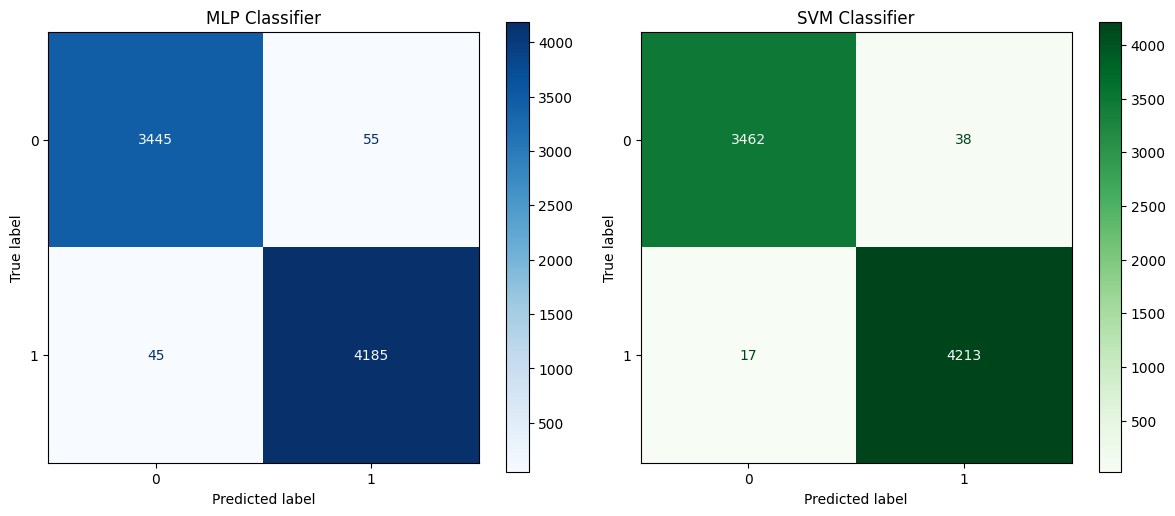

In [101]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# MLP Report
print("MLP Performance:")
print(classification_report(y_test, mlp_preds))

# SVM Report
print("SVM Performance:")
print(classification_report(y_test, svm_preds))

# Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, mlp_preds, ax=ax[0], cmap='Blues')
ax[0].set_title('MLP Classifier')

ConfusionMatrixDisplay.from_predictions(y_test, svm_preds, ax=ax[1], cmap='Greens')
ax[1].set_title('SVM Classifier')

plt.tight_layout()
plt.show()


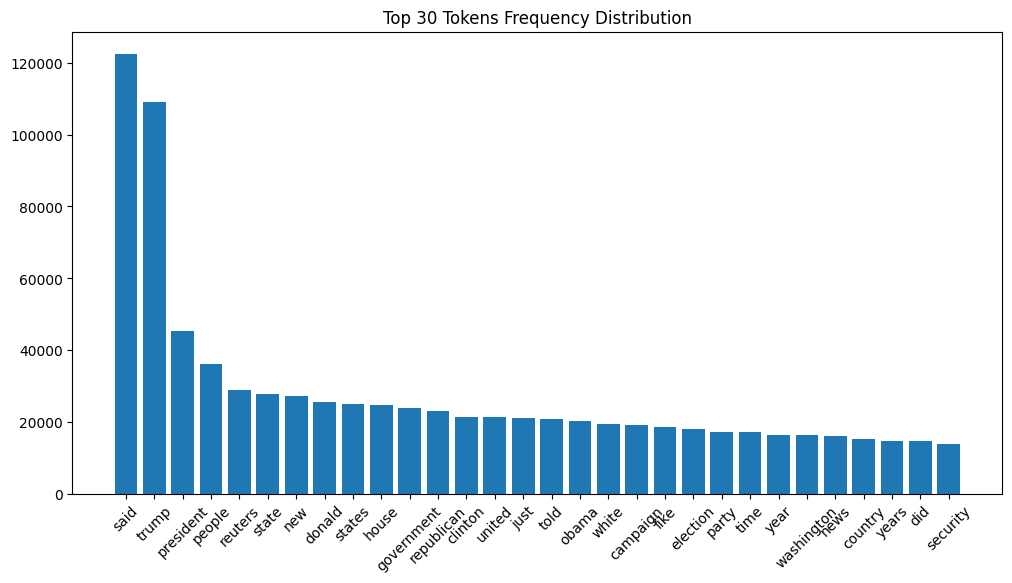

In [102]:
from collections import Counter
import matplotlib.pyplot as plt

all_tokens = []
for text in dataset['text']:
    tokens = tokenizer(text)
    all_tokens.extend(tokens)

# Count frequencies
freq_dist = Counter(all_tokens)

# Most common 30 tokens
common_tokens = freq_dist.most_common(30)
tokens, counts = zip(*common_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens, counts)
plt.xticks(rotation=45)
plt.title("Top 30 Tokens Frequency Distribution")
plt.show()


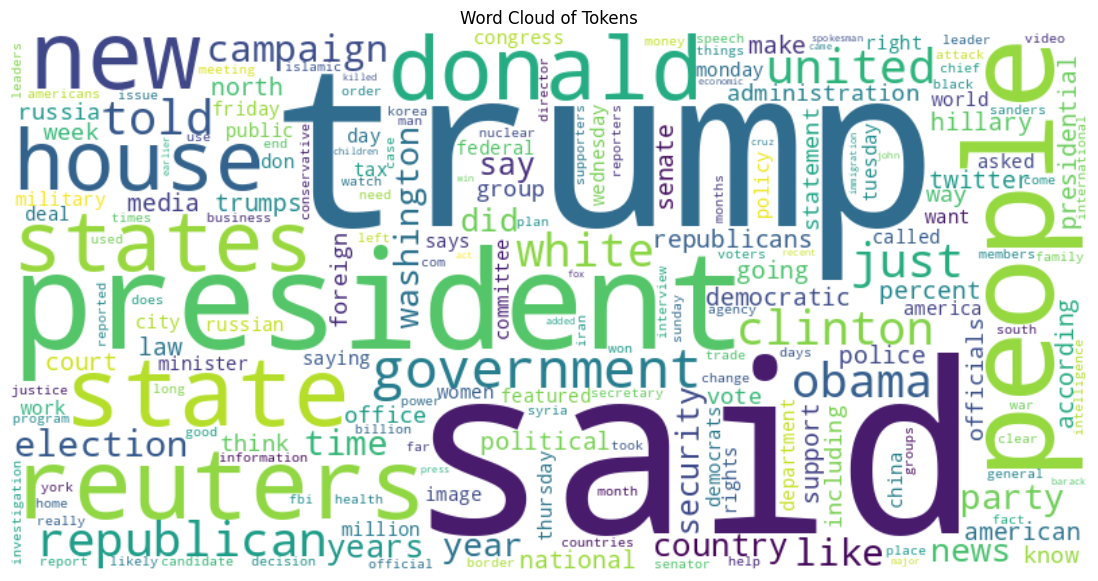

In [103]:
from wordcloud import WordCloud

#dict for wordcloud
word_freq = dict(freq_dist)

wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tokens")
plt.show()


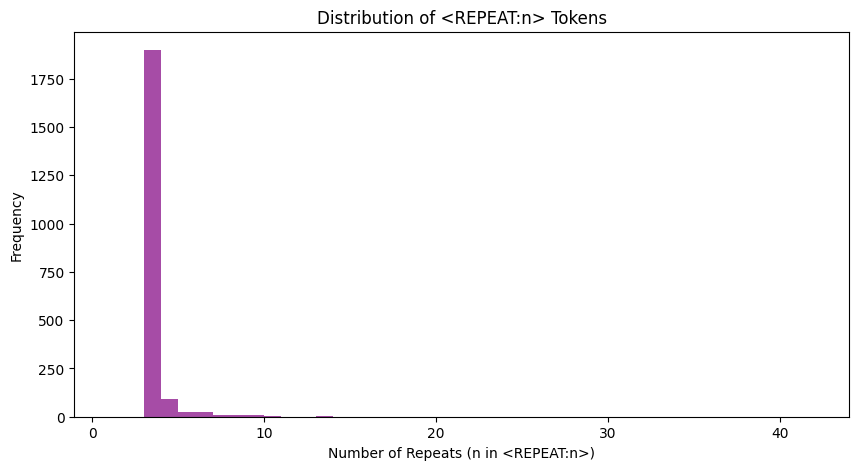

In [104]:
import re

repeat_tokens = [token for token in all_tokens if re.match(r"<REPEAT:\d+>", token)]

# Extract repeat counts
repeat_counts = [int(re.findall(r"\d+", token)[0]) for token in repeat_tokens]

plt.figure(figsize=(10,5))
plt.hist(repeat_counts, bins=range(1, max(repeat_counts)+1), color='purple', alpha=0.7)
plt.xlabel("Number of Repeats (n in <REPEAT:n>)")
plt.ylabel("Frequency")
plt.title("Distribution of <REPEAT:n> Tokens")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


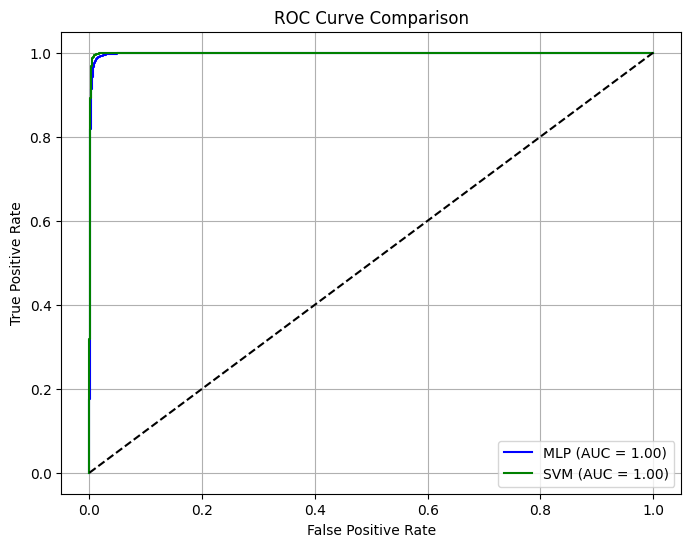

In [105]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

# MLP Probabilities
mlp_probs = mlp_model.predict_proba(X_test)[:, 1]

# Calibrate SVM to get probability estimates
calibrated_svm = CalibratedClassifierCV(svm_model, cv="prefit")
calibrated_svm.fit(X_train, y_train)
svm_probs = calibrated_svm.predict_proba(X_test)[:, 1]

# ROC curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)

# AUC
auc_mlp = auc(fpr_mlp, tpr_mlp)
auc_svm = auc(fpr_svm, tpr_svm)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.2f})", color='blue')
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')  # random baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [106]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, svm_preds)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9929


Analyze the impact of repeated‑character normalization and POS‑guided lemmatization on model performance.

In [107]:
#lets define tokenizer again for different approach

def tokenizer2(text):

    text = text.lower()

    text = clean_text_advanced(text)

    text = fix_contractions(text)

    text = re.sub(r"[^a-zA-Z0-9\s']", '', text)

    #to remove websites
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r"\b[\w.-]+\.com\S*","", text)
    text = re.sub(r"\b\w\b", "", text)

    words = text.split()

    tokens = []

    for token in words:
        if token in popular_emoticons:
            token = popular_emoticons[token]

        else:
          tokens.append(token)


    return remove_stopwords(tokens)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

def a(text):
    c = (tokenizer2(text))
    b = " ".join(c)
    return b

processed_corpus2 = [a(text) for text in dataset['text']]

tfidf_vectorizer2 = TfidfVectorizer(max_features=5000)
X_tfidf2 = tfidf_vectorizer2.fit_transform(processed_corpus2)



In [109]:
from sklearn.model_selection import train_test_split


X2 = X_tfidf2
y = dataset['label']

X_train2, X_test2, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)


SVM Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3500
           1       0.99      1.00      0.99      4230

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



<Figure size 600x500 with 0 Axes>

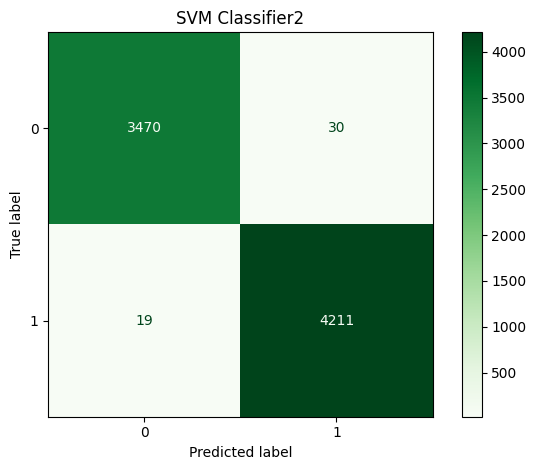

In [110]:
from sklearn.svm import LinearSVC
svm_model2 = LinearSVC()
svm_model2.fit(X_train2, y_train)
svm_preds2 = svm_model2.predict(X_test2)


from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# SVM Report
print("SVM Performance:")
print(classification_report(y_test, svm_preds2))

# Confusion Matrices
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, svm_preds2, cmap='Greens')
plt.title('SVM Classifier2')
plt.tight_layout()
plt.show()


In [111]:
accuracy = accuracy_score(y_test, svm_preds2)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9937


Final Report:

Tokenizer:

The tokenizer firsts pre-processes noises in the text data, like removal of website	 links, invalid words and social media handles.
Separates contractions into two different tokens
Replaces emoticons with words
Removes the stop words, which helps the training data to be diverse and focus more on important words which can be a distinguishing factor between fake and real news

Lemmatizer:

Takes input a list of tuples(words and their part of speech) and changes it back to a simpler form based on different filters applied, for example it changes peas into pea


Impact of repeated‑character normalization and POS‑guided lemmatization:
In my case there is no significant impact of normalization and lemmatization.
